<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/cifar10_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 116 (delta 46), reused 31 (delta 14), pack-reused 41
Receiving objects: 100% (116/116), 79.06 MiB | 29.02 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/TFG


In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
! git pull

Already up to date.


In [0]:
from cifar10_models import *
from utils import *
from adversarial_attacks import *

In [0]:
iv3 = inception_v3(pretrained=True)

In [0]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [0]:
test_loader = testloader_cifar10('./data', 256)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
test_model(iv3, device, test_loader)

100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


0.9541

In [0]:
adv_loader = testloader_cifar10('./data', 1)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
test_fgsm(iv3, device, './data/img1.png', 0.56)

In [0]:
def deepfool(model, device, image, label, output, num_classes=10, overshoot=0.02, max_iter=50):
  # Classes ordered by probability (descending)
  f_image = output.data.cpu().numpy().flatten()
  I = f_image.argsort()[::-1]
  I = I[0:num_classes]  # pick only num_classes 

  # Start from original image (copy)
  input_shape = image.cpu().detach().numpy()[0].shape   # (3,H,W)
  pert_image = copy.deepcopy(image)   # tensor of size (1,3,H,W)
  w = np.zeros(input_shape)
  r_tot = np.zeros(input_shape)

  loop_i = 0

  x = pert_image.clone().detach().requires_grad_(True)
  fs = model(x)
  k_i = label

  while k_i == label and loop_i < max_iter:

    pert = np.inf
    fs[0, I[0]].backward(retain_graph=True)
    grad_orig = x.grad.data.cpu().numpy().copy()

    for k in range(1, num_classes):
      zero_gradients(x)

      fs[0, I[k]].backward(retain_graph=True)
      cur_grad = x.grad.data.cpu().numpy().copy()

      # set new w_k and new f_k
      w_k = cur_grad - grad_orig 
      f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()
      
      pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

      # determine which w_k to use
      if pert_k < pert:
        pert = pert_k
        w = w_k
    
    # compute r_i and r_tot
    # Added 1e-4 for numerical stability
    r_i = (pert+1e-4) * w / np.linalg.norm(w)
    r_tot = np.float32(r_tot + r_i)

    if device == torch.device("cuda"):
      pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
    else:
      pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

    x = pert_image.clone().detach().requires_grad_(True)
    fs = model(x)
    k_i = np.argmax(fs.data.cpu().numpy().flatten())
    
    loop_i += 1

  r_tot = (1+overshoot)*r_tot

  return pert_image





  0%|          | 0/10000 [00:00<?, ?it/s]



  0%|          | 1/10000 [00:00<1:02:47,  2.65it/s]


======== RESULTS ========
Test Accuracy = 0 / 1 = 0.0
Average confidence = 0.724841296672821
Average time = 0.3043956756591797
Average magnitude of perturbations = 2.011592388153076
Model robustness = 0.03519053012132645


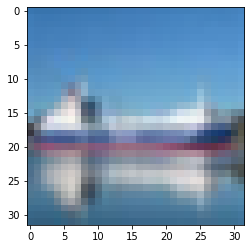

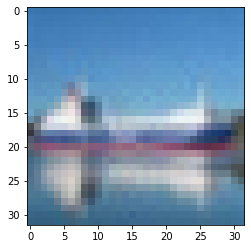

In [0]:
#params = {'epsilon': 0.4}
params = {'num_classes': 10, 'overshoot': 0.02, 'max_iter': 50}
adv_examples = attack_model(iv3, device, adv_loader, 'deepfool', params, iters=1)

plt.imshow(denormalize_cifar10(adv_examples[0][2]).transpose((1,2,0)))
plt.show()
plt.imshow(denormalize_cifar10(adv_examples[0][3]).transpose((1,2,0)))
plt.show()

In [0]:
def attack_model(model, device, test_loader, method, params, iters=10000):

  # Initialize the network and set the model in evaluation mode.
  model = model.to(device).eval()

  # Stat counters
  correct = 0
  confidence = 0
  total_time = 0
  ex_robustness = 0
  model_robustness = 0
  adv_examples = []

  i = 0

  # Loop (iters) examples in test set
  for data, target in pbar(test_loader):
    if i >= iters:
      break
    i += 1

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    if method in ['fgsm', 'deepfool']:
        data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    # If the initial prediction is wrong, dont botter attacking
    if init_pred.item() != target.item():
      continue

    if method == 'fgsm':
        # Call FGSM attack
        time_ini = time.time()
        perturbed_data = fgsm(model, data, params["epsilon"], output, target)
        time_end = time.time()
        total_time += time_end-time_ini
      
    elif method == 'deepfool':
        # Call DeepFool attack
        time_ini = time.time()
        perturbed_data = deepfool(model, device, data, target.item(), output, params["num_classes"], params["overshoot"], params["max_iter"])
        time_end = time.time()
        total_time += time_end-time_ini

    # Update model robustness
    p_norm = 2
    im_np = data.squeeze().detach().cpu().numpy()
    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
    delta = np.linalg.norm((adv_ex - im_np).flatten(), ord=p_norm)
    #delta = math.sqrt(32*32*3*params["epsilon"]**2)  # fgsm has a fixed delta(f,x) robustness
    ex_robustness += delta
    model_robustness += delta / np.linalg.norm(im_np.flatten(), ord=p_norm)

    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    confidence += F.softmax(output, dim=1).max(1, keepdim=True)[0].item()  # adv. confidence
    if final_pred.item() == target.item():
      correct += 1
    else:
      # Save some adv examples for visualization later
      if len(adv_examples) < 5:
        adv_examples.append( (init_pred.item(), final_pred.item(), im_np, adv_ex) )

  # Calculate stats
  final_acc = correct / float(iters)  # len(test_loader)
  avg_confidence = confidence / float(iters)
  avg_time = total_time / float(iters)
  avg_ex_robustness = ex_robustness / float(iters)
  model_robustness = model_robustness / float(iters)
  print("\n======== RESULTS ========")
  print("Test Accuracy = {} / {} = {}\nAverage confidence = {}\nAverage time = {}\nAverage magnitude of perturbations = {}\nModel robustness = {}"
    .format(correct, iters, final_acc, avg_confidence, avg_time, avg_ex_robustness, model_robustness))

  # Return adversarial examples
  return adv_examples